## Benchmark of coupled diffusion


### A three-component system for Garnet (Fe, Mg, Ca)

#### Outlined in [Vielzeuf and Saul, 2011](https://doi.org/10.1007/s00410-010-0557-4)



#### Ficks first law:

$$
J = -D \frac{dC}{dx}
$$

Where:
- _J_ is the diffusion flux, representing the amount of substance that will flow through a unit area per unit time (e.g., mol/m²·s).
- _D_ is the diffusion coefficient (or diffusivity), a constant that depends on the material and conditions (e.g., temperature).
- _C_ is the concentration of the diffusing substance.
- $\frac{dC}{dx}$ is the concentration gradient along the $x$-axis (change in concentration with respect to position).

Expanded for multicomponent diffusion:

$$
\mathbf{J}_i = -\sum_{j=1}^{N} D_{ij} \nabla C_j
$$

Where:
- $\mathbf{J}_i$ is the diffusion flux of component _i_.
- $D_{ij}$ is the diffusion coefficient matrix, where each $D_{ij}$ represents the diffusion coefficient of component _i_ with respect to the concentration gradient of component _j_.
- $\nabla C_j$ is the concentration gradient of component $j$.


## 

# Garnet benchmark
- Attempting to recreate fig 6

### Initial conditions
Given from figure 6 and 9

- Domain size of _0,0_ to _12,1_ $\mu$m
- Model duration to 10$^9$ s

$$
\xi_1 = Mg = 
\begin{cases} 
0.461185, &  x \leq 6, \\
0.4569965, & else
\end{cases}
$$

$$
\xi_2 = Fe = 
\begin{cases} 
0.5190967, &  x \leq 6, \\
0.50997849, & else
\end{cases}
$$

where:
$$
\xi_3 = 1 - \xi_1 - \xi_2
$$

### UW implementation

In [1]:
import underworld3 as uw
import numpy as np
import math

import sympy as sp
import UWDiffusion as DIF
import matplotlib.pyplot as plt

# if uw.mpi.size == 1:
#     import matplotlib.pyplot as plt

In [2]:
csize = uw.options.getReal(name='csize', default = 0.01)

degree = uw.options.getInt(name='degree', default = 1)

order = uw.options.getInt(name='order', default = 1)

In [3]:
### Scaling the model

# import unit registry to make it easy to convert between units
u = uw.scaling.units

### make scaling easier
ndim, nd = uw.scaling.non_dimensionalise, uw.scaling.non_dimensionalise
dim  = uw.scaling.dimensionalise 

### How to scale the time for diffusion and radioactive decay ???
### This works, for some reason ???
diffusive_rate    = 1e-20 * u.meter**2 /u.second


model_length      = 12 * u.micrometer ### scale the mesh radius to the zircon radius



KL = model_length
Kt = model_length**2 / diffusive_rate


scaling_coefficients  = uw.scaling.get_coefficients()
scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt

scaling_coefficients

[mass],1.0 kilogram
[length],1.2e-05 meter
[temperature],1.0 kelvin
[time],14400000000.0 second
[substance],1.0 mole


In [4]:
xmin, xmax = 0, nd(12*u.micrometer)
ymin, ymax = 0, nd(1*u.micrometer)

In [5]:
import os

outputPath = './output/multicomponent_diffusion_benchmarks/'

os.makedirs(outputPath, exist_ok=True)

In [6]:
mesh_qdegree = degree
mesh_qdegree

1

In [7]:

# mesh = uw.meshing.StructuredQuadBox( minCoords=(xmin, ymin), maxCoords=(xmax, ymax), elementRes=(300,25) )

mesh = uw.meshing.UnstructuredSimplexBox(minCoords=(xmin, ymin), maxCoords=(xmax, ymax), cellSize=csize)


In [8]:
mg_field = 0
fe_field = 1
ca_field = 2

# Symbolic matrix entries (D_ij) to test new substitution workflow
D_11, D_12, D_21, D_22 = sp.symbols("D_11 D_12 D_21 D_22")
D_matrix_sym = sp.Matrix([
    [D_11, D_12],
    [D_21, D_22],
])

# Numerical values from benchmark (non-dimensional)
D_FeFe = nd(4.5e-19 * u.meter**2 / u.second)
D_FeMg = nd(-0.4e-19 * u.meter**2 / u.second)
D_MgFe = nd(-4.74e-19 * u.meter**2 / u.second)
D_MgMg = nd(0.66e-19 * u.meter**2 / u.second)

D_matrix = sp.Matrix([[D_MgMg, D_MgFe],
                     [D_FeMg, D_FeFe]])

model = DIF.MulticomponentDiffusionModel(
    component_names=["Mg", "Fe", "Ca"],
    mesh=mesh,
    degree=degree,
    order=order,
)

model.set_diffusion_matrix(D_matrix_sym)

model.set_diffusion_values({
    D_11: D_MgMg,
    D_12: D_MgFe,
    D_21: D_FeMg,
    D_22: D_FeFe,
})

### Set up the initial values

In [9]:
x = mesh.X[0]

xi1 = sp.Piecewise(
    (0.461185, x <= nd(6 * u.micrometer)),
    (0.4569965, True),
)

xi2 = sp.Piecewise(
    (0.5190967, x <= nd(6 * u.micrometer)),
    (0.50997849, True),
)

with mesh.access(*model.mesh_vars):
    model.mesh_vars[mg_field].data[:, 0] = uw.function.evaluate(xi1, model.mesh_vars[mg_field].coords)
    model.mesh_vars[fe_field].data[:, 0] = uw.function.evaluate(xi2, model.mesh_vars[fe_field].coords)
    model.mesh_vars[ca_field].data[:, 0] = 1.0 - model.mesh_vars[mg_field].data[:, 0] - model.mesh_vars[fe_field].data[:, 0]

In [10]:
for _solver in model.solvers:
    _solver.petsc_options['snes_rtol'] = 1e-12
    _solver.petsc_options['snes_atol'] = 1e-6
    _solver.petsc_options["snes_converged_reason"] = None

In [11]:
duration_1 = 1e5 * u.second
duration_2 = 518400 * u.second

# Conservative timestep controls for coupled diffusion
max_dt = 1e4 * u.second
time_step_factor = 1.0

model.run_simulation(
    duration=duration_1,
    max_dt=max_dt,
    time_step_factor=time_step_factor,
    min_dt=1.0 * u.second,
 )



Step 0, dt: 4361.050455306922 second, Time: 0.00 second
  Nonlinear Solver_12_ solve converged due to CONVERGED_FNORM_ABS iterations 2
  Nonlinear Solver_13_ solve converged due to CONVERGED_FNORM_ABS iterations 2

Step 1, dt: 4361.050455306922 second, Time: 4361.05 second
  Nonlinear Solver_12_ solve converged due to CONVERGED_FNORM_ABS iterations 2
  Nonlinear Solver_13_ solve converged due to CONVERGED_FNORM_ABS iterations 2

Step 2, dt: 4361.050455306922 second, Time: 8722.10 second
  Nonlinear Solver_12_ solve converged due to CONVERGED_FNORM_ABS iterations 2
  Nonlinear Solver_13_ solve converged due to CONVERGED_FNORM_ABS iterations 2

Step 3, dt: 4361.050455306922 second, Time: 13083.15 second
  Nonlinear Solver_12_ solve converged due to CONVERGED_FNORM_ABS iterations 2
  Nonlinear Solver_13_ solve converged due to CONVERGED_FNORM_ABS iterations 2

Step 4, dt: 4361.050455306922 second, Time: 17444.20 second
  Nonlinear Solver_12_ solve converged due to CONVERGED_FNORM_ABS ite

In [12]:

x = np.linspace(xmin, xmax, 1001)
y = np.zeros_like(x) + (ymax / 2)
profile_coords = np.column_stack([x, y])

In [13]:
A_profile_1 = uw.function.evaluate(model.mesh_vars[mg_field].sym[0], profile_coords)
B_profile_1 = uw.function.evaluate(model.mesh_vars[fe_field].sym[0], profile_coords)

(0.452, 0.466)

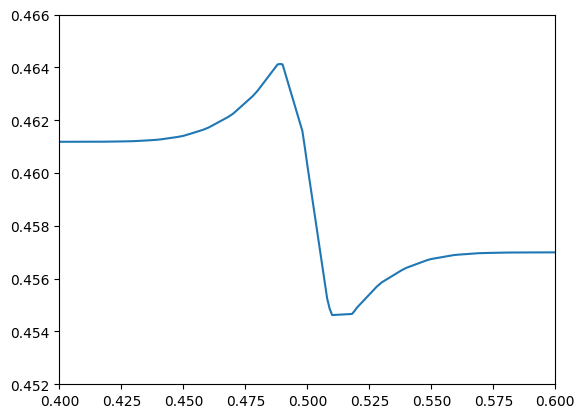

In [14]:
plt.plot(x, A_profile_1)
plt.plot(x, B_profile_1)
plt.plot(x, 1-A_profile_1-B_profile_1)

plt.xlim(0.4, 0.6)
plt.ylim(0.452, 0.466)

In [15]:
model.run_simulation(
    duration=duration_2,
    max_dt=max_dt,
    time_step_factor=time_step_factor,
    min_dt=1.0 * u.second,
 )

A_profile_2 = uw.function.evaluate(model.mesh_vars[mg_field].sym[0], profile_coords)
B_profile_2 = uw.function.evaluate(model.mesh_vars[fe_field].sym[0], profile_coords)


Step 23, dt: 4361.050455306922 second, Time: 100000.00 second
  Nonlinear Solver_12_ solve converged due to CONVERGED_FNORM_ABS iterations 2
  Nonlinear Solver_13_ solve converged due to CONVERGED_FNORM_ABS iterations 2

Step 24, dt: 4361.050455306922 second, Time: 104361.05 second
  Nonlinear Solver_12_ solve converged due to CONVERGED_FNORM_ABS iterations 2
  Nonlinear Solver_13_ solve converged due to CONVERGED_FNORM_ABS iterations 2

Step 25, dt: 4361.050455306922 second, Time: 108722.10 second
  Nonlinear Solver_12_ solve converged due to CONVERGED_FNORM_ABS iterations 2
  Nonlinear Solver_13_ solve converged due to CONVERGED_FNORM_ABS iterations 2

Step 26, dt: 4361.050455306922 second, Time: 113083.15 second
  Nonlinear Solver_12_ solve converged due to CONVERGED_FNORM_ABS iterations 2
  Nonlinear Solver_13_ solve converged due to CONVERGED_FNORM_ABS iterations 2

Step 27, dt: 4361.050455306922 second, Time: 117444.20 second
  Nonlinear Solver_12_ solve converged due to CONVERG

In [16]:
Mg_paper = np.array([
    (3.0554956807897984, 46.12225405069445),
    (3.175767174002468, 46.122662966222165),
    (3.2960386672151376, 46.122662966222165),
    (3.4181324557795145, 46.124162323157115),
    (3.6627405626048164, 46.12351448501858),
    (3.777124640065817, 46.122662966222165),
    (3.8948729550992, 46.12351448501858),
    (4.017667626491156, 46.12552537491616),
    (4.127005347593583, 46.12582827530706),
    (4.258210612916496, 46.126615816323394),
    (4.378482106129166, 46.13056866642462),
    (4.4987535993418355, 46.137816471080534),
    (4.739296585767175, 46.157829701605515),
    (4.859568078979844, 46.172278050251386),
    (4.979839572192514, 46.191633385229814),
    (5.1001110654051836, 46.21616831689261),
    (5.220382558617853, 46.24561023488798),
    (5.329720279720281, 46.27859608745685),
    (5.4281242287124645, 46.31091555916575),
    (5.526528177704649, 46.345067578239586),
    (5.635865898807076, 46.37469123646949),
    (5.73426984779926, 46.37284138051078),
    (5.7927025915261225, 46.33482197251743),
    (5.835656696244932, 46.30044385993754),
    (5.85454134101193, 46.260303932850476),
    (5.865475113122173, 46.22611859473364),
    (5.887342657342659, 46.187135314424964),
    (5.902649938296998, 46.14635280579436),
    (5.922335115864529, 46.11645729446363),
    (5.935451254627726, 46.07318418736885),
    (5.952945290004115, 46.02201863196372),
    (5.971688899335959, 45.962231774182634),
    (5.98756890168655, 45.91425235226427),
    (6.004088852324147, 45.87177057244072),
    (6.009800904977377, 45.8281892641982),
    (6.05839325380502, 45.709770053475935),
    (6.029965446318388, 45.79430379746835),
    (6.031668449197862, 45.75891897380356),
    (6.073216783216784, 45.66266025857984),
    (6.089617441382148, 45.62750033845529),
    (6.1078403948992195, 45.59114093278278),
    (6.122418757712876, 45.55215765247411),
    (6.148191220544162, 45.51413824448076),
    (6.188021390374333, 45.47718980572666),
    (6.25909090909091, 45.447543429967446),
    (6.37936240230358, 45.45790262333618),
    (6.483233237350886, 45.49124627699181),
    (6.576170300287949, 45.52391976353257),
    (6.680041135335254, 45.557105530359436),
    (6.794845742492803, 45.58861928702855),
    (6.915117235705472, 45.61710706879258),
    (7.035388728918142, 45.63959742281681),
    (7.155660222130812, 45.65745340086029),
    (7.275931715343481, 45.67122022362664),
    (7.396203208556151, 45.68103419629176),
    (7.5164747017688205, 45.68812206543879),
    (7.63674619498149, 45.69343796729907),
    (7.757017688194161, 45.69670929152077),
    (7.87728918140683, 45.699162784687054),
    (7.9975606746195, 45.699844310566576),
    (8.11783216783217, 45.699980615742476),
    (8.238103661044839, 45.70270671926057),
    (8.358375154257509, 45.702843024436476),
    (8.478646647470178, 45.702843024436476),
    (8.598918140682848, 45.702843024436476),
    (8.719189633895517, 45.702843024436476),
    (8.839461127108187, 45.702843024436476),
    (8.959732620320857, 45.702843024436476),
    (9.041735911147677, 45.702843024436476),
    (4.624615384615385, 46.1493670886076),
    (3.516923076923077, 46.12405063291139)
])

In [17]:
Fe_paper = np.array([
    (3.0882969971205263, 51.91246621815881),
    (3.2161380248710567, 51.91147022701102),
    (3.449111476758536, 51.91246621815881),
    (3.5693829699712056, 51.91246621815881),
    (3.6896544631838752, 51.91246621815881),
    (3.809925956396545, 51.91246621815881),
    (4.050468942821884, 51.909756823017126),
    (4.291011929247224, 51.904943204687896),
    (4.411283422459894, 51.90223380954621),
    (4.531554915672563, 51.897602364859566),
    (4.656746606334842, 51.88971231288214),
    (4.772097902097903, 51.876688307954474),
    (4.892369395310572, 51.86186768495721),
    (5.012640888523242, 51.84264718950763),
    (5.1329123817359115, 51.81891103548857),
    (5.242250102838339, 51.79231882391275),
    (5.340654051830523, 51.765147681751095),
    (5.4335911147675855, 51.7362252745673),
    (5.515594405594406, 51.707772903882955),
    (5.592130810366106, 51.678479016239926),
    (5.663200329082683, 51.64839668027523),
    (5.7233360756890175, 51.62054625955954),
    (5.778004936240231, 51.5920165602898),
    (5.827206910736323, 51.56380527284227),
    (5.869119703825587, 51.52994748241427),
    (5.923907856849034, 51.49709799608993),
    (5.958412176059236, 51.46541601978034),
    (6.0021472645002065, 51.430231513426484),
    (6.055113122171947, 51.397435095739176),
    (6.098848210612918, 51.366867560807314),
    (6.13881941587824, 51.3378693412849),
    (6.204422048539697, 51.305445920303605),
    (6.264557795146032, 51.27627939738945),
    (6.3301604278074874, 51.24783460793897),
    (6.401229946524065, 51.21942014342394),
    (6.483233237350886, 51.19014899948249),
    (6.570703414232827, 51.161014317750556),
    (6.669107363225011, 51.13273934793859),
    (6.78391197038256, 51.10370018975332),
    (6.9041834635952295, 51.07834303009393),
    (7.024454956807899, 51.05773310123836),
    (7.144726450020569, 51.042101975420934),
    (7.256493898258605, 51.030536228828446),
    (7.374335664335666, 51.02015819746543),
    (7.4946071575483355, 51.01442600927334),
    (7.614878650761005, 51.008199800314685),
    (7.735150143973675, 51.006208279099425),
    (7.855421637186344, 51.0049346318106),
    (7.975693130399014, 51.00308205393594),
    (8.095964623611684, 51.00308205393594),
    (8.216236116824355, 51.002387337232946),
    (8.336507610037025, 51.001345262178454),
    (8.456779103249694, 51.00053475935829),
    (8.577050596462364, 51.00053475935829),
    (8.697322089675033, 51.00053475935829),
    (8.817593582887703, 51.00053475935829),
    (8.937865076100373, 51.00053475935829),
    (9.025335252982313, 51.000789488816054),
    (3.332307692307692, 51.91182795698924),
    (3.9230769230769234, 51.91182795698924),
    (4.163076923076924, 51.909677419354836)
])

(0.45, 0.52)

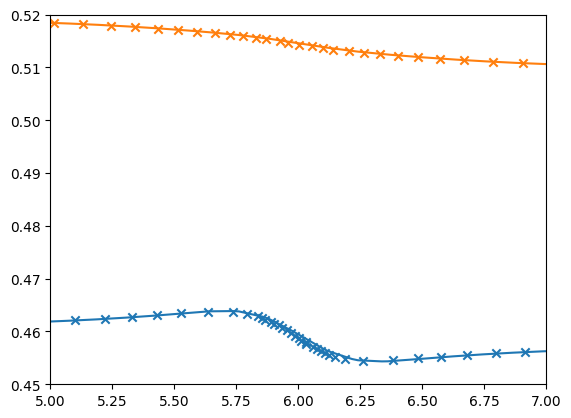

In [18]:
# plt.plot(x, A_profile_1)
# plt.plot(x, B_profile_1)
# plt.plot(x, 1-A_profile_1-B_profile_1)


plt.plot(x*12, A_profile_2)
plt.plot(x*12, B_profile_2)
plt.plot(x*12, 1-A_profile_2-B_profile_2)

plt.scatter(Mg_paper[:,0], Mg_paper[:,1]/100, marker='x')
plt.scatter(Fe_paper[:,0], Fe_paper[:,1]/100, marker='x')

# plt.scatter(Fe_paper[:,0]/12, 1-(Mg_paper[:,1]/100)-(Fe_paper[:,1]/100), marker='x')

plt.xlim(5, 7)
plt.ylim(0.45, 0.52)